<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

# Neural networks

## Basics
Let's start by relating neural networks to regression. Consider a simple case where we have two nodes, $1$ and $X$ pointing to an outcome $Y$. What does this mean? Let's first put some context around the problem. Imagine that we want to use a subject's BMI $X$ to predict their blood pressure, $Y$. This diagram represents that.

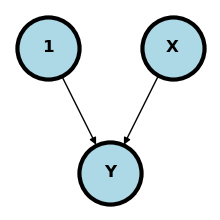

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl

plt.figure(figsize=[2, 2])
#G = nx.Graph()
G = nx.DiGraph()

G.add_node("1", pos = (0, 1) )
G.add_node("X", pos = (1, 1) )
G.add_node("Y", pos = (.5, 0))
G.add_edge("1", "Y")
G.add_edge("X", "Y")
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 1.3])
ax.set_ylim([-.3, 1.3])
plt.show()

To interpret this diagram as a neural network, consider the following rule:

:::{note}
Parent nodes that point to a child node are multiplied by weights then added together then operated on by an activation function to form the child node.
:::

If the parent nodes point to the outcome, then the nodes are combined the operated on by a known function, called the **activation function** to form a prediction. So, in this case, this is saying that the intercept (node labeled $1$)times a weight plus BMI (node labeled $X$) times a different weight get combined to form a prediction for SBP $Y$. Or, in other words

$$
\hat Y = g(w_0 \times 1 + w_1 \times X)
$$

where $g$ is a function that we specify. So in this case, if $w_0 = 120$, $w_1 = .1$ and $g$ is an idenity function, $g(a) = a$, and a subject had a BMI of 30, then the prediction would be 

$$
\hat Y = g(120 + .1 * 30) = 120.3
$$

Note $g$ is not shown in the diagram (though maybe you could with the shape of the child node) or something like that0. Also not shown in the daigram is:

+ The loss function, i.e. how to measure the different between $\hat Y$ and $Y$.
+ The way the loss function combines subjects; we have multiple BMIs and SBPs
+ How we obtain the weights, $W_0$ and $W_1$; this is done by minmizing the loss function using an algorithm

So, imagine the case where $g$ is an identity function, our loss function for different subjects is squared error and we combine different losses by adding them up. Then, our weights are obtained by minmizing

$$
\sum_{i=1}^N (Y_i - \hat Y_i)^2 
$$

and so, presuming our optimization algorithm works well, it should be idential to linear regression. 

Consider a different setting. Imagine if our $Y$ is 0 or 1 based on whether or not the subject is taking anti-hypertensive mediations. Further, let $g$ be the sigmoid function, $g(a) = 1 / \{1 + \exp(-a)\}$. Our prediction is

$$
\hat Y = \{1 + \exp(-W_0 - W_1 X)\}^{-1}
$$

which is the logistic regression prediction with intercept $W_0$ and slope $W_1$. Consider a case where
$W_0 = -4$, $W_1 = .1$ and $X=30$, then our $\hat Y = 1 / \{1 + \exp[-(-4 + .1\times 30)\}]\approx .27$. Thus, this model estimates a 27% probability that a subject with a BMI of 30 has hypertension.

Further, if we specify that the loss function is binary cross entropy

$$
- \sum_{i=1}^n \{ Y_i \log(\hat Y_i) + (1 - Y_i) \log(1 - \hat Y_i)\} / N
$$

then minmizing our loss function is identical to maximizing the likelihood for logistic regression. 

In [8]:
1 / (1 + np.exp(-(-4 + .1 * 30)))

0.2689414213699951

## More layers

Of course, there'd be no point in using NNs for problems that we can just solve with generalized linear models. NNs get better when we add more layers, since then they can discover interactions and non-linearities. Consider the following model. Notice we quit explicitly adding the bias (intercept) term / node. In general assume the bias term is included unless otherwise specified.

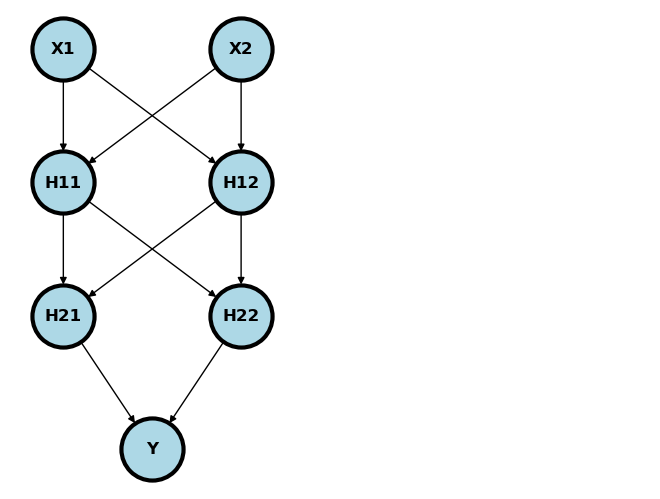

In [9]:
#plt.figure(figsize=[2, 2])
G = nx.DiGraph()
G.add_node("X1",  pos = (0, 3) )
G.add_node("X2",  pos = (1, 3) )
G.add_node("H11", pos = (0, 2) )
G.add_node("H12", pos = (1, 2) )
G.add_node("H21", pos = (0, 1) )
G.add_node("H22", pos = (1, 1) )
G.add_node("Y", pos = (.5, 0))
G.add_edges_from([ ("X1", "H11"),  ("X1", "H12"),  ("X2", "H11"),  ("X2", "H12")])
G.add_edges_from([("H11", "H21"), ("H11", "H22"), ("H12", "H21"), ("H12", "H22")])
G.add_edges_from([("H21", "Y"), ("H22", "Y")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 3.3])
ax.set_ylim([-.3, 3.3])
plt.show()

Usually, the nodes are added in so called layers. $(X_1, X_2)$ is the input layer, $(H_{11}, H_{12})$ is the first hidden layer, $(H_{21}, H_{22})$ is the second hidden layer and $Y$ is the output layer. Imagine plugging an $X_1$ and $X_2$ into this network. It would feed forward through the network as

$$
\begin{align}
H_{11} = & g_1(W_{011} + W_{111} X_1 + W_{211} X_2) \\
H_{12} = & g_1(W_{012} + W_{112} X_1 + W_{212} X_2) \\
H_{21} = & g_2(W_{021} + W_{121} H_{11} + W_{221} H_{12}) \\
H_{22} = & g_2(W_{022} + W_{122} H_{12} + W_{222} H_{12}) \\
\hat Y = & g_3(W_{031} + W_{131} H_{21} + W_{231} H_{22})
\end{align}
$$

where $g_k$ are specified activation functions. Typically, we would have a different activation function for the output layer than the others, and the other would have the same activation function. So, for example, if $Y$ was binary, like hypertension diagnosis, then $g_1=g_2$ and $g_3$ would be a sigmoid.

## Activation functions

The output activation function tends to be based on the structure of the outcome. For example, a binary outcome would likely have a sigmoidal, or other function from $\mathbb{R}$ to $[0, 1]$ so as to model a probability. Historically, the internal activation functions were binary thresholds. This was owning to the fact that neural networks were models of (biological) neurons and the threshold was a model of an action potential being propigated. However, modern neural networks have less of a direct connection to their biological motivation and other activation functions tend to be used. The most popular right now is the rectified linear unit (RELU) function. This is simply:

$$
RELU(a) = \left\{
\begin{array}{ll}
a & \text{if $a>0$} \\
0 & \text{otherwise}
\end{array}
\right.
= a \times I(a > 0)
$$

Plotted, this is:

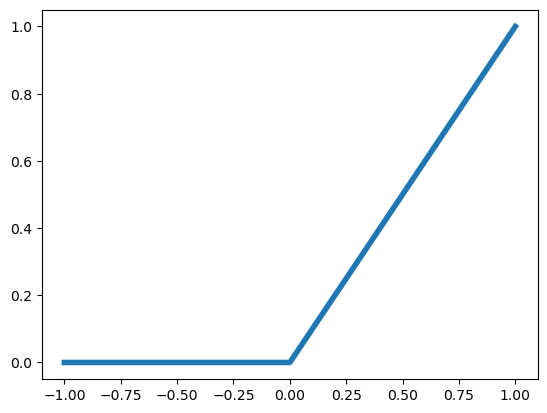

In [10]:
plt.plot( [-1, 0, 1], [0, 0, 1], linewidth = 4);

If a bias term is included, then the fact that the RELU is centered at zero isn't important, since the intercept term effectively shifts the function around. These kinds of splin terms are incredibly flexible. Just to show you an example, let's fit the sine function using a collection of shifted RELUs. This is just

$$
Y = \sin(X) + \epsilon
$$

being fit with

$$
\sum_{i=1}^N \left\{ Y_i - W_{021} - \sum_{j=1}^{d} W_{j21} g(W_{1j1} X_i- W_{0j1}) \right\}^2
$$

where the $W_{kj}$ are the weights for layer $k$. Below, we're just setting $W_{1j1} = 1$ and specifying the $W_{0j1}$ at a sequence of values. 

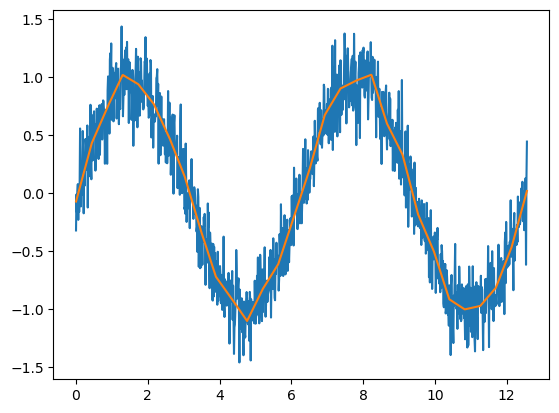

In [11]:
## Generate some data, a sine function on 0,4*pi
n = 1000
x = np.linspace(0, 4 * np.pi, n)
y = np.sin(x) + .2 * np.random.normal(size = n)

## Generate the spline regressors
df = 30
knots = np.linspace(x.min(), x.max(), df)
xmat = np.zeros((n, df))
for i in range(0, df): xmat[:,i] = (x - knots[i]) * (x > knots[i])

## Fit them
from sklearn.linear_model import LinearRegression
yhat = LinearRegression().fit(xmat, y).predict(xmat)

## Plot them versus the data
plt.plot(x, y);
plt.plot(x, yhat);

This corresponds to a network like depicted below if there were $d=3$  hidden nodes, there was a relu activation function at the first layer, then a identity activation function for the output layer and the weights for the first layer are specified.

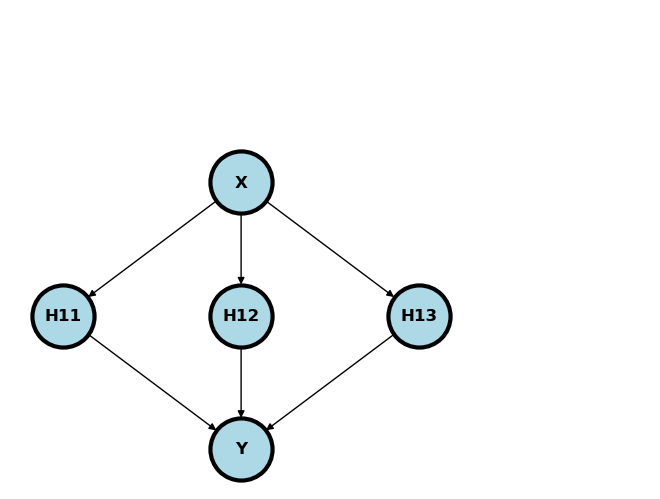

In [12]:
G = nx.DiGraph()
G.add_node("X",  pos =  (1, 2) )
G.add_node("H11", pos = (0, 1) )
G.add_node("H12", pos = (1, 1) )
G.add_node("H13", pos = (2, 1) )
G.add_node("Y", pos = (1, 0))
G.add_edges_from([("X", "H11"),  ("X", "H12"),  ("X", "H13")])
G.add_edges_from([("H11", "Y"), ("H12", "Y"), ("H13", "Y")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 3.3])
ax.set_ylim([-.3, 3.3])
plt.show()

We can actually fit this function way better using splines and a little bit more care. However, this helps show how even one layer of RELU activated nodes can start to fit complex shapes.

## Optimization

One of the last bits of the puzzle we have to figure out is how to obtain the weights. A good strategy would be to minimize the loss function. However, it's hard to minmize. If we had a derivative, we could try the following. Let $L(W)$ be the loss function for weights $W$. Note, we're omitting the fact that this is a function of the data (predictors and outcome) as well, since that's a set of fixed numbers. Consider updating parameters as

$$
W^{(new)} = W^{(old)} - e * L'(W^{(old)})
$$

What does this do? It moves the parameters by a small amount, $e$, called the **learning rate**, in the direction the opposite of the gradient. Think of a one dimensional convex function. If the derivative at a point is positive, then that point is larger than where the minimum is. Similarily, if the derivative is negative, it's smaller. So, the idea is to head a small amount in the opposite direction of the derivative. How much? How about along the line of the derivative? That's all gradient descent does, just in more than one dimension.  

How do we get the gradient? Consider the following. If $X$ is our vector of predictors and $Y$ is our vector of outputs, a neural network with 3 layers, can be thought of as, where $L_k$ is layer $K$ and $W_k$ are the weights for that layer:

$$
L_3(L_2(L_1(X, W_1), W_2) W_3)
$$

Or a series of function compositions. Recall from calculus, if we want the derivative of composed functions we have a really simple rule called the chain rule:

$$
\frac{d}{dx}f(g(x)) = f'(g(x)) g'(x)
$$

I.e. if $h=f(u)$ and $u = g(x)$ then $\frac{dh}{dx} = \frac{dh}{du}\frac{du}{dx}$. Thus, characterized this way, the chain rule formally acts like fractions (though this is a symbolic equivalence having entirely different underlying meanings). 

If we use the chain rule on our composed loss functions, we wind up bookkeeping backwards through our neural network. That is why it's called backwards propagation (backprop). 

So, our algorithm goes something like this. 
Given, $W^{(new)}$, network, $\phi(X, W)$, which depends on the predictors and the weights 
and loss, $L(Y, \hat Y)$, which depends on the observed and predicted outputs.

0. Set $W^{(old)}=W^{(new)}$
1. Calculate $\hat Y = \phi(X, W^{(old)})$ and loss $L(Y, \hat Y)$.
1. Use back propagation to get to get a numerical approximation to $\frac{d}{dW} L\{Y, \phi(X, W)\} |_{W=W^{(old)}} = L'(W^{(old)})$
3. Update $W^{(new)} = W^{(old)} - e L'(W^{(old)})$
4. Go to step 0.